In [1]:
import os
from collections import Counter
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hypergraphx as hgx

from tqdm.notebook import tqdm

from tqdm.auto import tqdm
tqdm.pandas()

import sys
sys.path += ['../']

from src.plot_configs import w_inc_fullpage, h_inc, set_plot_configs
set_plot_configs()

from src.filters import get_svmis

FIG_FOLD = "../paper/figures/"
if not os.path.exists(FIG_FOLD):
    os.makedirs(FIG_FOLD)


In [2]:
def load_nasdaq():
    """ Load Nasdaq dataset and return a sequence of hypergraph objects.
    """
    import glob
    all_files = glob.glob("../data/SP100/SP100_202012_proc_*.parquet.bro")
    all_files = sorted(all_files)

    for file in all_files:
        date_stock = file.split("/")[-1].replace(".parquet.bro", "").split("_")[-1]

        # load the data as a bipartite network
        df = pd.read_parquet(file, engine="pyarrow")

        print(f"Date: {date_stock} | #nodes: {df.a.nunique()} | #hyperedges: {df.b.nunique()}")

        # load sector metadata
        mapping = pd.read_csv(f'../data/SP100/mappings/MappingSP100_{date_stock}.csv')
        n100 = pd.read_csv('../data/SP100/mappings/sp100.tsv', sep='\t')

        #n100_d = dict(n100[[1,2]].values)
        n100_labels = dict(mapping[['tick','id']].values)
        n100['id'] = n100['Symbol'].apply(lambda x: n100_labels.get(x, np.nan))
        n100_sector = dict(n100[['id','Sector']].values)
        n100_ids = dict(n100[['id','Symbol']].values)
        n100_labels_1 = dict(mapping[['id','tick']].values)
        n100_sector[82] = 'Energy'
        n100_sector[73] = 'Energy'
        n100_sector[62] = 'Energy'
        n100_sector[7] = 'Financials'
        n100_sector[14] = 'Health Care'

        # load correlations
        corr = pd.read_csv(f'../data/SP100/correlations/CorrelationMatrix100_{date_stock}.csv')
        corr.index = corr.columns

        # transform to hypergraph
        H = hgx.Hypergraph(weighted=True)
        for b, group in df.groupby('b'):
            nodes = sorted(group['a'].tolist())

            if H.check_edge(nodes):
                weight = H.get_weight(nodes) + 1
                H.set_weight(nodes, weight)
            else:
                H.add_edge(nodes, weight=1)

        # attention: the 14th is problematic because unknown sectors..
        # add node metadata
        for node in H.get_nodes():
            H.set_attr_to_node_metadata(node, "sector", n100_sector.get(node, 'Unknown'))

        yield date_stock, H, corr, n100_labels_1


### Nasdaq dataset

In [3]:
def purity(counter):

    n = sum(counter.values())

    return n / (n - 1) * (1 - len(counter) / n)

In [4]:
# compute the results or load existing ones
result_file_svmis = "../results/SP100/svmis_all_nasdaq.parquet"

if not os.path.exists(os.path.dirname(result_file_svmis)):
    print("Creating directory for results...")
    os.makedirs(os.path.dirname(result_file_svmis))

    svmis_all_df = []
    for date_stock, H, corr, n100_labels_1 in load_nasdaq():

        # extract SVMIS
        svmis_df = get_svmis(H, min_size=2, max_size=10, alpha=0.01, approximate=True)
        svmis_df = pd.concat(svmis_df).reset_index(drop=True)

        # compute sizes and the count of categories in each svmis
        svmis_df.loc[:, "size"] = svmis_df.group.apply(len)
        svmis_df.loc[:, "categs_count"] = svmis_df.group.apply(lambda g: Counter([H.get_node_metadata(n)["sector"] for n in g]))
        svmis_df.loc[:, "purity"] = svmis_df.categs_count.apply(purity)
        svmis_df.loc[:, "date"] = date_stock

        svmis_df.loc[:, "avg_corr"] = svmis_df.group.apply(lambda group: 
                                                        np.mean([corr.loc[n100_labels_1[i],n100_labels_1[j]] for i,j in combinations(group, 2)]))

        svmis_all_df.append(svmis_df)

    svmis_all_df = pd.concat(svmis_all_df).reset_index(drop=True)

    # save results
    svmis_all_df.to_parquet(result_file_svmis, index=False, engine="pyarrow")    

else:
    print("Loading existing results...")
    svmis_all_df = pd.read_parquet(result_file_svmis, engine="pyarrow")

svmis_all_df.head()

Loading existing results...


,group,pvalue,fdr,size,categs_count,purity,date,avg_corr
0,"[0, 1, 13, 21, 27, 51, 70, 89, 94, 95]",3.227865e-13,True,10,"{'Communication Services': 1.0, 'Consumer Disc...",0.444444,2020-12-01,0.179631
1,"[0, 9, 12, 37, 49, 57, 59, 74, 88, 91]",1.835928e-12,False,10,"{'Communication Services': 1.0, 'Consumer Disc...",0.333333,2020-12-01,0.137700
2,"[13, 29, 33, 46, 48, 50, 52, 54, 66, 68]",3.048063e-13,True,10,"{'Communication Services': None, 'Consumer Dis...",0.444444,2020-12-01,0.236115
3,"[12, 16, 29, 32, 33, 46, 52, 80, 94, 95]",1.115421e-14,True,10,"{'Communication Services': 1.0, 'Consumer Disc...",0.555556,2020-12-01,0.463207
4,"[26, 33, 41, 43, 48, 61, 66, 67, 80, 95]",1.036316e-13,True,10,"{'Communication Services': None, 'Consumer Dis...",0.555556,2020-12-01,0.303657


In [5]:
# count total number of sets and svmis
svmis_all_df.shape[0], svmis_all_df.query("fdr").shape[0]

(11844159, 41839)

In [6]:
# on day 2020-12-14 there are some unknown sectors, we should discard that day purity results
svmis_all_df.loc[:, "has_unk"] = svmis_all_df.categs_count.apply(lambda c: not c["Unknown"] is None )
svmis_all_df.query("has_unk == True").date.unique()

array(['2020-12-14'], dtype=object)

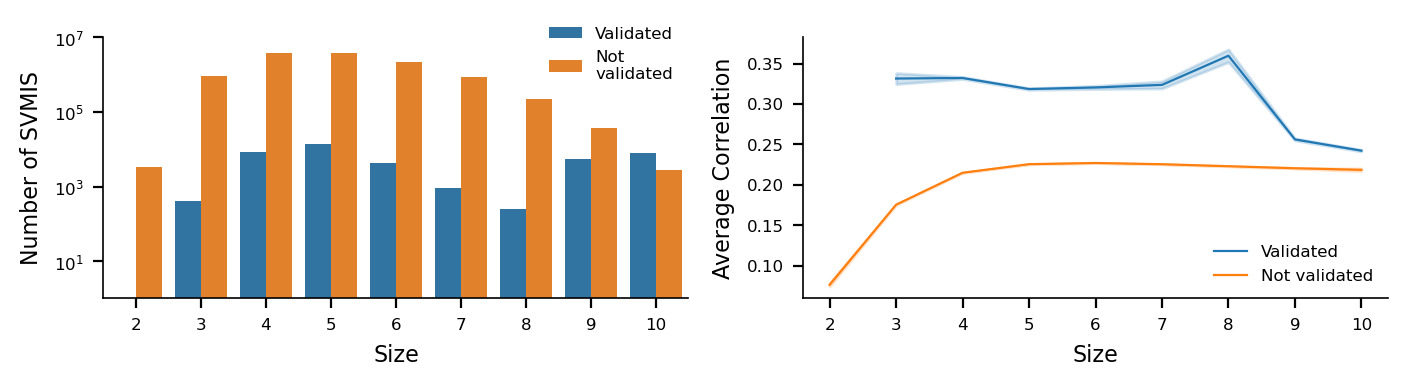

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(w_inc_fullpage, h_inc))

# plot counts of svmis by size
ax = axs[0]
sns.countplot(data=svmis_all_df, x="size", hue="fdr", hue_order=[True, False], ax=ax)

ax.set_yscale("log")
ax.set_ylim(1, 1e7)
ax.set_yticks([1e1, 1e3, 1e5, 1e7])

# remove minor thicks from y axis
ax.yaxis.set_minor_locator(plt.NullLocator())

ax.set_ylabel("Number of SVMIS")
ax.set_xlabel("Size")


ax = axs[1]
sns.lineplot(data=svmis_all_df, x="size", y="avg_corr", hue="fdr", hue_order=[True, False], estimator="mean", errorbar="se", ax=ax)

#ax.set_ylim(0.5, 1.0)
ax.set_ylabel("Average Correlation")
ax.set_xlabel("Size")

# remove spines and add legend
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax, leg_loc in zip(axs[1:], ["lower right"]):
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Validated", "Not validated"], loc=leg_loc, title=None, frameon=False)

# handle the first legend separately
ax = axs[0]
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Validated", "Not\nvalidated"], loc="upper right", bbox_to_anchor=(1., 1.1), title=None, frameon=False)

fig.tight_layout()

fig_file_name = os.path.join(FIG_FOLD, "Nasdaq_SVMIS.pdf")
if not os.path.exists(fig_file_name):
    fig.savefig(fig_file_name, dpi=300, bbox_inches='tight')